In [14]:
import numpy as np #TRa vetores e matrizes
import pandas as pd #manipula planilhas e trata dados
import matplotlib.pyplot as plt #plotagem de gráficos
import seaborn as sns #plotagem de gráficos
import warnings #para ignorar os warnings, comuns em data science
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

from dateutil.relativedelta import relativedelta #trabalha com datas
from scipy.optimize import minimize #para funções de minimização

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook #para barras de progresso no jupyter

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [15]:
import matplotlib
matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [16]:
#definindo função:

def mean_absolute_error(y_true, y_pred):
   return np.mean(np.abs((y_true - y-pred)/y_true))*100 
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y=pd.Series(y)
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Análise do gráfico da série temporal\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [17]:
#Trabalhando com a base de dados inicial
ads = pd.read_csv('POP.csv', index_col=['date'], parse_dates=['date'])
#index_col nomeia as linhas!

In [18]:
ads.head()

,realtime_start,value,realtime_end
date,,,
1952-01-01,2019-12-06,156309.0,2019-12-06
1952-02-01,2019-12-06,156527.0,2019-12-06
1952-03-01,2019-12-06,156731.0,2019-12-06
1952-04-01,2019-12-06,156943.0,2019-12-06
1952-05-01,2019-12-06,157140.0,2019-12-06


In [19]:
#removendo as colunas realtime_start e realtime_end
col=['realtime_start','realtime_end']
ads.drop(col, axis=1, inplace=True)

In [20]:
ads.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


In [21]:
ads.shape #816 linhas e 1 coluna apos limpe

(816, 1)

In [22]:
ads.describe()

,value
count,816.000000
mean,243847.767826
std,50519.140567
min,156309.000000
25%,201725.250000
50%,239557.500000
75%,289364.250000
max,330309.946000


In [23]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 1952-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


In [24]:
ads.isnull().sum()

value    0
dtype: int64

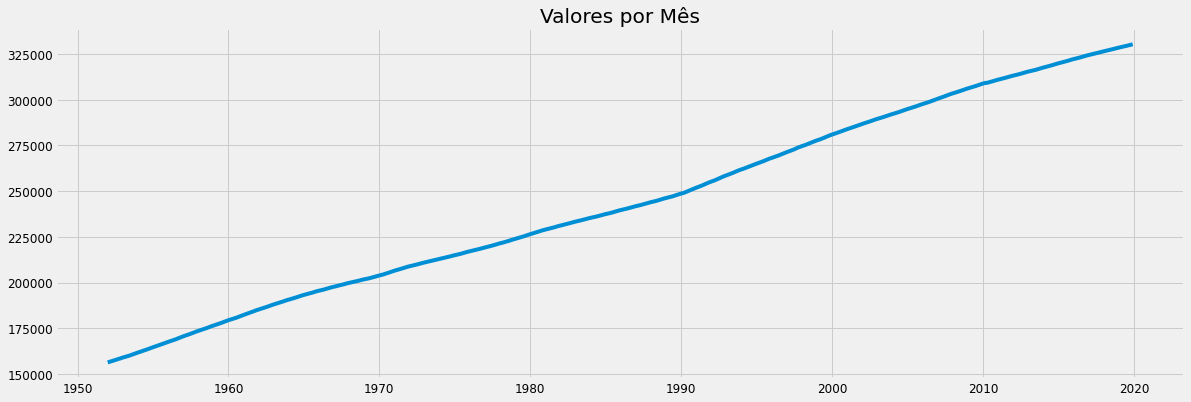

In [25]:
plt.figure(figsize=(18,6))
plt.plot(ads)
plt.title("Valores por Mês")
plt.show()

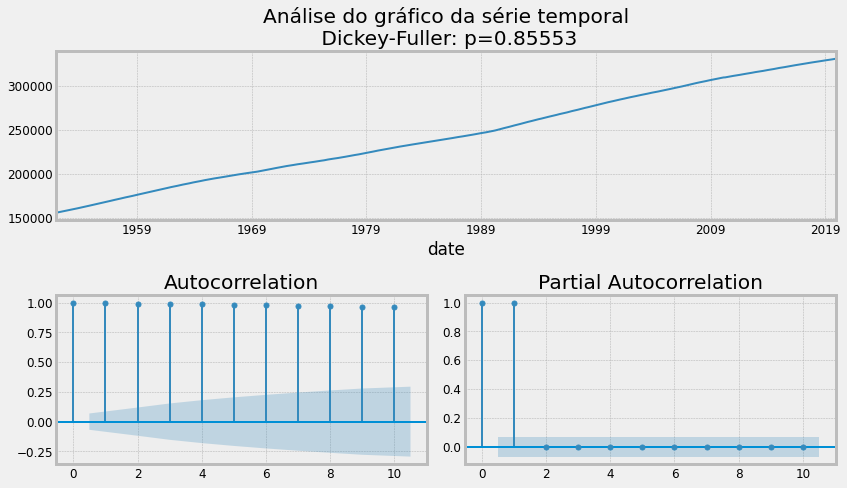

In [26]:
#Plotando algumas tendencias!
tsplot(ads.value,lags=10)

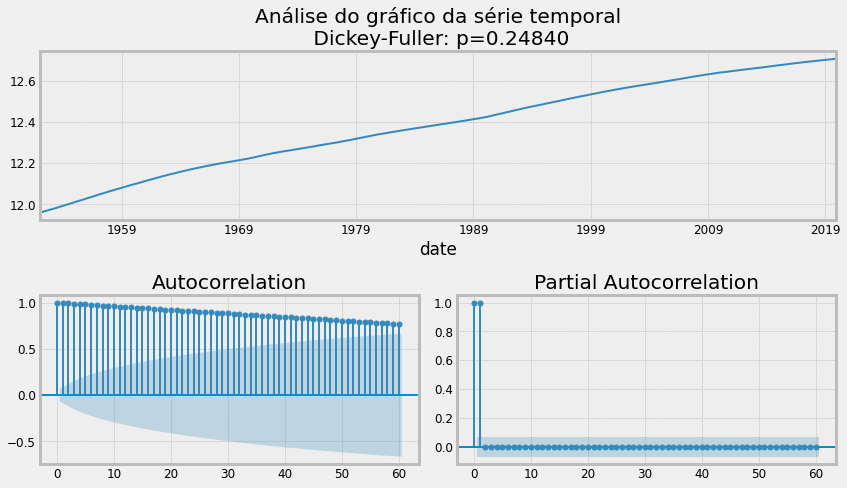

In [27]:
ads_log=np.log(ads.value)
tsplot(ads_log, lags=60)

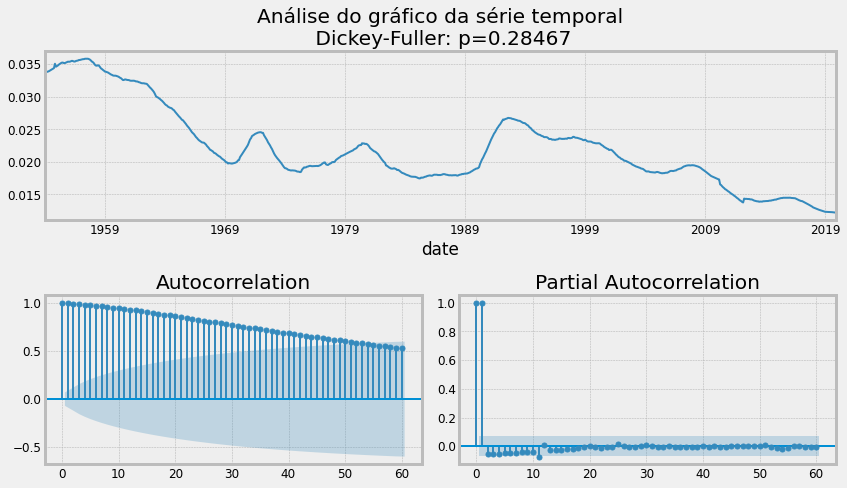

In [28]:
#verificando a diferenã diária
ads_log_diff = ads_log - ads_log.shift(24)
tsplot(ads_log_diff[24:], lags=60)

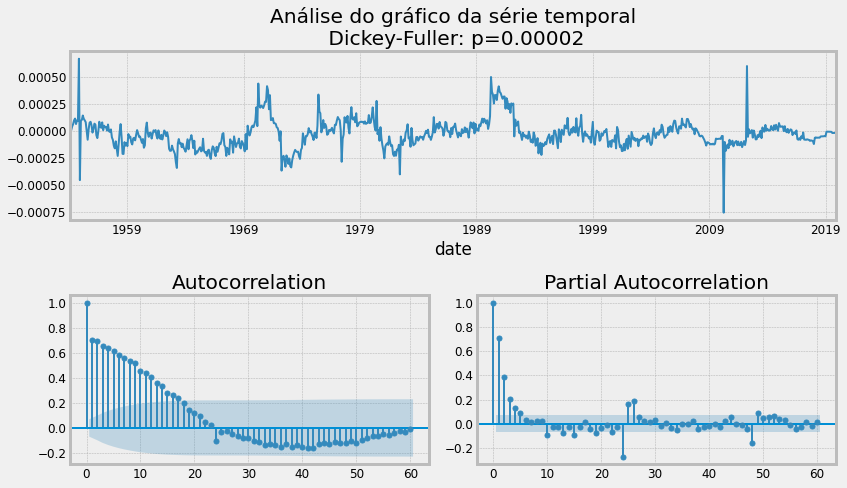

In [29]:
ads_log_diff = ads_log_diff - ads_log_diff.shift(1)
tsplot(ads_log_diff[24+1:], lags = 60)

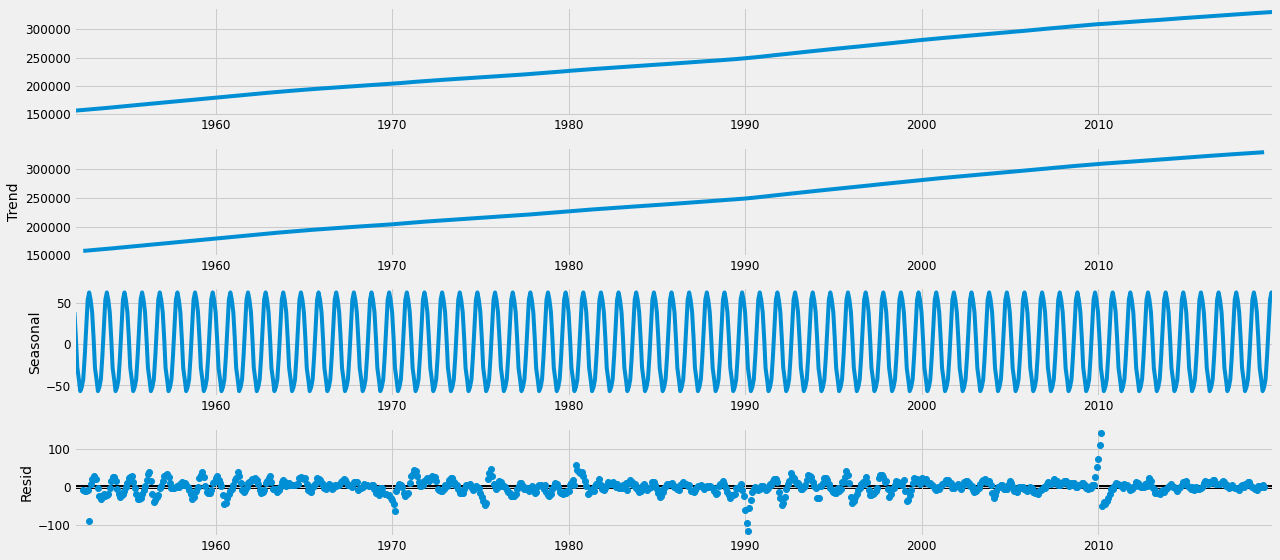

In [30]:
#Plotando graficos: Original, Tendencia, sazional e do Residuo
from pylab import rcParams
rcParams['figure.figsize']=18,8
decomposicao = sm.tsa.seasonal_decompose(ads, model='additive')
fig = decomposicao.plot()
plt.show()

In [31]:
#Função de pesquisa dos parametros q,p Q, P para o Modelo Sarima!
#Definindo valores iniciais e limites para eles!
ps=range(2,5)
d=1 #primeira diferença
qs = range(2,5)
Ps = range(0,2)
D=1 #secunda diferença
Qs= range(0,2)
s = 24 #duração da temporada (season) ainda é 24 [1 dia = 24 horas]

#criando lista com todos as combinações possiveis dos parametros
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)#Lista dos Parametros de Arima
len(parameters_list)#Tamanho da lista
def optimizeSARIMA(y, parametros_list, d, D, s):
    """Retorna o dataframe com parametros e AIC correspondentes
    
        y - series temporal
        parametros_lista - lista com (p,q P, Q) Tuplas
        d - ordem da integração do modelo ARIMA
        D - ordem da integração sazonal
        s = cumprimento da temporada
    """    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [32]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(ads, parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

Wall time: 5min 42s


In [33]:
#Parametros e AIC

result_table.head()
min(result_table.aic)

6625.97982030831

In [80]:
#Setando parametros para obter o menor AIIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.value, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  816
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 24)   Log Likelihood               -3306.990
Date:                              Mon, 15 Nov 2021   AIC                           6625.980
Time:                                      19:56:00   BIC                           6654.020
Sample:                                  01-01-1952   HQIC                          6636.757
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2807      2.187      0.128      0.898      -4.006       4.567
ar.L2          0.69

In [81]:
%%time
warnings.filterwarnings("ignore")
mod=sm.tsa.statespace.SARIMAX(ads, order=(3, 1, 2), seasonal_order=(0, 1, 1, 24),
                            enforce_stationarity=False,
                            enforce_invertibility=False)

#Fit do modelo
result=mod.fit()

Wall time: 10.9 s


In [82]:
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6136      0.470      1.307      0.191      -0.307       1.534
ar.L2          0.3688      0.463      0.797      0.426      -0.539       1.276
ar.L3         -0.0012      0.001     -1.510      0.131      -0.003       0.000
ma.L1         -0.2110      0.470     -0.449      0.653      -1.132       0.710
ma.L2         -0.2479      0.281     -0.882      0.378      -0.798       0.303
ma.S.L24      -0.8010      0.019    -42.083      0.000      -0.838      -0.764
sigma2       223.8432      2.430     92.119      0.000     219.081     228.606


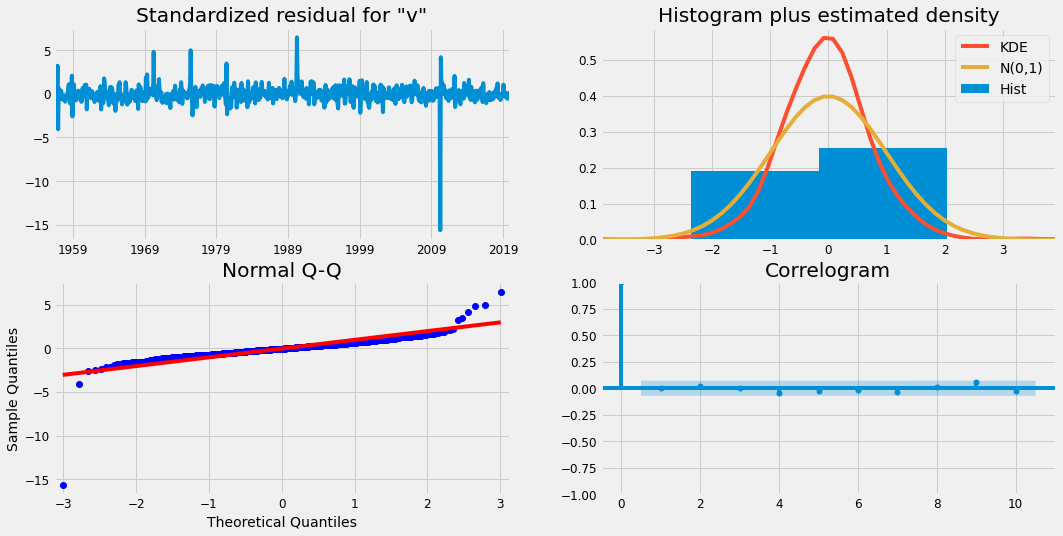

In [83]:

result.plot_diagnostics(figsize=(16,8))
plt.show()

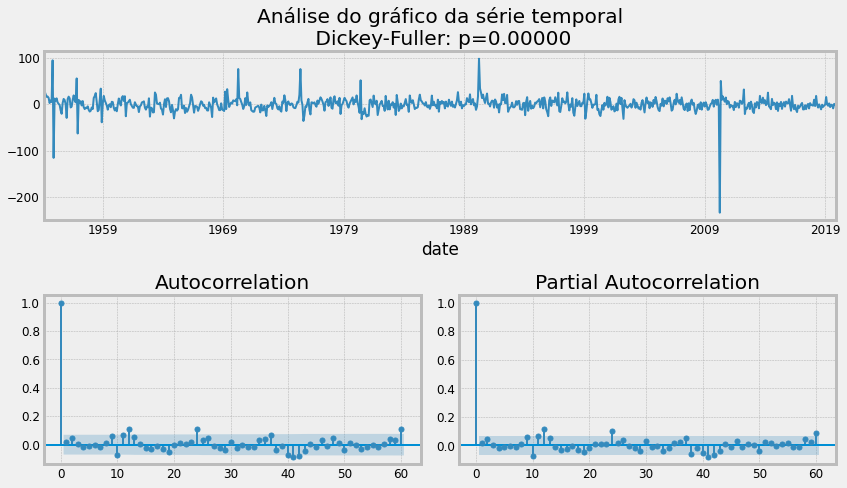

In [84]:
#modelo diagnostico para verificar quaisquer problemas incomuns

tsplot(best_model.resid[24+1:], lags = 60)

In [85]:
#criando função para plotar o moldeo SARIMA
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    
    

In [86]:
#previsão para 120 dias!!

plotSARIMA(ads, best_model,120)


NameError: name 'mean_absolute_percentage_error' is not defined